# Assignment 4
## Jesse Ellin
## Sequence Models
### Task 1

### Data Source
The data was pulled from https://www.kaggle.com/datasets/spsayakpaul/arxiv-paper-abstracts

The data set contains titles, abstracts, and arXiv paper categories from 51774 papers on arxiv.org. While we could use keyword-seeking to find specific words that map to categories, it is better to treat the text as sequence data to determine which words are significant to the text. To solve this problem, I will be using Tensorflow.

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from constants import VOCAB_SIZE, MODEL_INPUT, STOPWORDS

Num GPUs Available:  1


In [2]:
df = pd.read_csv("arxiv_data.csv")

In [3]:
df.head()

,titles,summaries,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']"
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV']
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']"


The original data has the terms as a string representation of a list. To parse this, we need to convert these strings to literal lists. I will store them as a set so we can use them for multilabel encoding

In [4]:
all_terms = set()
for term in df["terms"]:
    for t in re.split("[,;]", term.strip('][')):
        if not t.strip(" \'\n"):
            continue
        all_terms.add(t.strip(" \'\n"))

In [5]:
len(all_terms)

788

Prepare multilabel encoding columns

In [6]:
for term in all_terms:
    df[term] = 0

C:\Users\iamje\AppData\Local\Temp/ipykernel_5408/2932473953.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[term] = 0


In [7]:
df.head()

,titles,summaries,terms,03B52,65R30,D.2.5,quant-ph,K.3.8,62-07l,58J35,...,68T07 (Primary) 46N10,55R35,62M20,49N10,58D10 (Secondary),68U10 (Secondary),Artificial intelligence,H.2,35CXX,53A20
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV'],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Assign multilabel column assignment

In [8]:
for term in all_terms:
    df.loc[df["terms"].str.contains(term)==True, term] = 1

C:\Users\iamje\AppData\Local\Temp/ipykernel_5408/392173422.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df.loc[df["terms"].str.contains(term)==True, term] = 1


In [9]:
df.head()

,titles,summaries,terms,03B52,65R30,D.2.5,quant-ph,K.3.8,62-07l,58J35,...,68T07 (Primary) 46N10,55R35,62M20,49N10,58D10 (Secondary),68U10 (Secondary),Artificial intelligence,H.2,35CXX,53A20
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV'],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Check which terms are actually needed

In [10]:
for term in all_terms:
    print(term, df[term].unique())

03B52 [0 1]
65R30 [0 1]
D.2.5 [0 1]
quant-ph [0 1]
K.3.8 [0 1]
62-07l [0 1]
58J35 [0 1]
math.CA [0 1]
92-XX [0 1]
F.1.3 [0 1]
H.4.0 [0 1]
68P30 [0 1]
03G10 [0 1]
H.1.1 [0 1]
49N45 [0 1]
eess.IV [0 1]
65C20 [0 1]
65D19 [0 1]
q-bio.CB [0 1]
41A30 [0 1]
68T01 (Primary) [0]
05C21 [0 1]
62L10 [0 1]
35A18 [0 1]
cs.MM [0 1]
90C59 [0 1]
92C55 [0 1]
65F22 [0 1]
68U10(secondary) [0]
62-09 [0 1]
I.1.4 [0 1]
60G15 (Primary) 68W10 [0]
cond-mat.dis-nn [0 1]
49-06 (Primary) [0]
D.4.6 [0 1]
math.OC [0 1]
J.5 [0 1]
math.RA [0 1]
90-08 [0 1]
F.4.1 [0 1]
35J20 [0 1]
82C32 (Primary) [0]
J.2.5 [0 1]
60L10 (Primary) 60L20 (Secondary) [0]
90B22 [0 1]
68T20 [0 1]
62P30 [0 1]
H.2.4 [0 1]
15A69 [0 1]
60G40 [0 1]
60-06 [0 1]
D.2.11 [0 1]
82B20 [0 1]
86-08 (Secondary) [0]
q-fin.GN [0 1]
physics.app-ph [0 1]
I.3.5 [0 1]
cs.FL [0 1]
nlin.PS [0 1]
68T07(Primary) [0]
econ.TH [0 1]
nlin.CG [0 1]
91G80 [0 1]
68T07 [0 1]
62-XX [0 1]
physics.comp-ph [0 1]
91A20 [0 1]
57Z25 (Secondary) [0]
52C25 [0 1]
J.6 [0 1]
68T42 [0 1

In [11]:
to_drop = [term for term in all_terms if len(df[term].unique())==1]

In [12]:
df = df.drop(columns=to_drop)

In [13]:
df.head()

,titles,summaries,terms,03B52,65R30,D.2.5,quant-ph,K.3.8,62-07l,58J35,...,astro-ph.SR,C.2,H.3.4,55R35,62M20,49N10,Artificial intelligence,H.2,35CXX,53A20
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV'],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Pull data

In [14]:
X = np.array([" ".join([w for w in s.split() if w not in STOPWORDS]) for s in df["summaries"]])

In [15]:
Y = df[df.columns[3:]].to_numpy()

In [16]:
num_classes = Y.shape[1]

Convert text to padded token sequences
### Note on pre-processing:
We remove stopwords defined by the nltk library. We do this to minimize the input feature space and remove common words that could throw off the model. Once we have done this, we set the vocab size to be slightly less than the number of unique words in the filtered dataset. We do this to guarantee that some unknown words will be in our training data, since we cannot guarantee that our data contains all possible words that will be encountered. We then pad the token sequences to a fixed length for our model inputs.

In [17]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")

In [18]:
tokenizer.fit_on_texts(X)

In [19]:
for i,(k,v) in enumerate(tokenizer.word_index.items()):
    if i == len(tokenizer.word_index.keys())-1:
        print(i,k,v)

61464 definining 61465


In [20]:
x_tokens = tokenizer.texts_to_sequences(X)

In [21]:
word_index = tokenizer.word_index
word_index = {k : v+3 for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
word_index["<UNUSED>"] = 3

In [22]:
X_pad = pad_sequences(x_tokens, value=word_index["<PAD>"], padding="post", maxlen=MODEL_INPUT)

Split data into train, test, validate

In [23]:
x_train, x_test, y_train, y_test = train_test_split(X_pad, Y, test_size=1/20, random_state=0)

In [24]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1/10, random_state=0)

### Part 1, 2
Since we have multilabel data, we want to see the accuracy on the top *n* values. We will also look at recall, since we'd rather suggest incorrect labels than miss potential labels, especially with such a large (>700) label field.

When hidden layers need activation, I use tanh activation for quick but convergence with less risk of overfitting. Final layers use softmax activation. I use bidirectional layers for all RNN layers to encapsulate backwards-context.

We see that the different metrics have immensely different results across the three models. While the validation recall suggests LSTM did better than RNN, we prioritize top-k accuracy which suggests RNN performed better on validation data. We see that the validation recall breaks the tie in favor of GRU. I think the LSTM model underperforms because it's more complex, so while it can learn to forget it may forget too much, resulting in lower validation accuracy. GRUs however introduce enough complexity to get an edge over RNNs without overfitting as much as LSTM.

In [104]:
class Model():
    def __init__(self, **kwargs):
        self.__build(**kwargs)
    
    def __build(self, **kwargs):
        pass

    def __call__(self, X, **kwargs):
        return self.model.predict(X, **kwargs)

    def train(self, X, Y, **kwargs):
        return self.model.fit(X, Y, **kwargs)

class GRUModel(Model):
    def __init__(self, **kwargs):
        self.__build(**kwargs)
    
    def __build(self, input_shape, output_shape, opt="adam", **kwargs):
        self.model = keras.Sequential()
        self.model.add(keras.layers.Embedding(VOCAB_SIZE, input_shape//2))
        self.model.add(keras.layers.Dropout(rate=0.1))
        self.model.add(keras.layers.Bidirectional(keras.layers.GRU(input_shape//4, return_sequences=True)))
        self.model.add(keras.layers.Bidirectional(keras.layers.GRU(input_shape//4)))
        self.model.add(keras.layers.Dropout(rate=0.1))
        self.model.add(keras.layers.Dense(output_shape, activation="softmax"))
        self.model.compile(optimizer=opt,
                           loss="categorical_crossentropy",
                           metrics=[tf.keras.metrics.CategoricalAccuracy(name="accuracy_gru"), tf.keras.metrics.TopKCategoricalAccuracy(k=3, name="top_k_gru"), tf.keras.metrics.Recall(thresholds=0.3, name="recall_gru")])
        print(self.model.summary())

class LSTMModel(Model):
    def __init__(self, **kwargs):
        self.__build(**kwargs)
    
    def __build(self, input_shape, output_shape, opt="adam", **kwargs):
        self.model = keras.Sequential()
        self.model.add(keras.layers.Embedding(VOCAB_SIZE, input_shape//2))
        self.model.add(keras.layers.Dropout(rate=0.1))
        self.model.add(keras.layers.Bidirectional(keras.layers.LSTM(input_shape//4, return_sequences=True)))
        self.model.add(keras.layers.Bidirectional(keras.layers.LSTM(input_shape//4)))
        self.model.add(keras.layers.Dropout(rate=0.1))
        self.model.add(keras.layers.Dense(output_shape, activation="softmax"))
        self.model.compile(optimizer=opt,
                           loss="categorical_crossentropy",
                           metrics=[tf.keras.metrics.CategoricalAccuracy(name="accuracy_lstm"), tf.keras.metrics.TopKCategoricalAccuracy(k=3, name="top_k_lstm"), tf.keras.metrics.Recall(thresholds=0.3, name="recall_lstm")])
        print(self.model.summary())
        
class RNNModel(Model):    
    def __init__(self, **kwargs):
        self.__build(**kwargs)
        
    def __build(self, input_shape, output_shape, opt="adam", **kwargs):
        self.model = keras.Sequential()
        self.model.add(keras.layers.Embedding(VOCAB_SIZE, input_shape//2))
        self.model.add(keras.layers.Dropout(rate=0.1))
        self.model.add(keras.layers.Bidirectional(keras.layers.SimpleRNN(input_shape//4, return_sequences=True, activation="tanh")))
        self.model.add(keras.layers.Bidirectional(keras.layers.SimpleRNN(input_shape//4, activation="tanh")))
        self.model.add(keras.layers.Dropout(rate=0.1))
        self.model.add(keras.layers.Dense(output_shape, activation="softmax"))
        self.model.compile(optimizer=opt,
                           loss='categorical_crossentropy',
                           metrics=[tf.keras.metrics.CategoricalAccuracy(name="accuracy_rnn"), tf.keras.metrics.TopKCategoricalAccuracy(k=3, name="top_k_rnn"), tf.keras.metrics.Recall(thresholds=0.3, name="recall_rnn")])
        print(self.model.summary())

In [123]:
rnn_model = RNNModel(input_shape=MODEL_INPUT, output_shape=num_classes, opt=tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.99, beta_2=0.99))

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, None, 128)         6400000   
                                                                 
 dropout_52 (Dropout)        (None, None, 128)         0         
                                                                 
 bidirectional_52 (Bidirecti  (None, None, 128)        24704     
 onal)                                                           
                                                                 
 bidirectional_53 (Bidirecti  (None, 128)              24704     
 onal)                                                           
                                                                 
 dropout_53 (Dropout)        (None, 128)               0         
                                                                 
 dense_26 (Dense)            (None, 708)             

In [124]:
early_stop_rnn = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=2, verbose=1, restore_best_weights=True)
rnn_history = rnn_model.train(X=x_train, Y=y_train, validation_data=(x_val, y_val), verbose=1, batch_size=1000, callbacks=[early_stop_rnn], epochs=100)

Epoch 1/100
45/45 [==============================] - 50s 1s/step - loss: 13.9047 - accuracy_rnn: 0.0021 - top_k_rnn: 0.0072 - recall_rnn: 0.0000e+00 - val_loss: 13.5796 - val_accuracy_rnn: 0.0037 - val_top_k_rnn: 0.0150 - val_recall_rnn: 0.0000e+00
Epoch 2/100
45/45 [==============================] - 50s 1s/step - loss: 13.7010 - accuracy_rnn: 0.0046 - top_k_rnn: 0.0187 - recall_rnn: 0.0000e+00 - val_loss: 13.4009 - val_accuracy_rnn: 0.0075 - val_top_k_rnn: 0.0279 - val_recall_rnn: 0.0000e+00
Epoch 3/100
45/45 [==============================] - 47s 1s/step - loss: 13.5195 - accuracy_rnn: 0.0120 - top_k_rnn: 0.0420 - recall_rnn: 0.0000e+00 - val_loss: 13.2119 - val_accuracy_rnn: 0.0195 - val_top_k_rnn: 0.0679 - val_recall_rnn: 0.0000e+00
Epoch 4/100
45/45 [==============================] - 48s 1s/step - loss: 13.3199 - accuracy_rnn: 0.0351 - top_k_rnn: 0.1085 - recall_rnn: 0.0000e+00 - val_loss: 12.9908 - val_accuracy_rnn: 0.0620 - val_top_k_rnn: 0.1872 - val_recall_rnn: 0.0000e+00
Epoc

In [125]:
lstm_model = LSTMModel(input_shape=MODEL_INPUT, output_shape=num_classes, opt=tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.99, beta_2=0.99))

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, None, 128)         6400000   
                                                                 
 dropout_54 (Dropout)        (None, None, 128)         0         
                                                                 
 bidirectional_54 (Bidirecti  (None, None, 128)        98816     
 onal)                                                           
                                                                 
 bidirectional_55 (Bidirecti  (None, 128)              98816     
 onal)                                                           
                                                                 
 dropout_55 (Dropout)        (None, 128)               0         
                                                                 
 dense_27 (Dense)            (None, 708)             

In [126]:
early_stop_lstm = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10, verbose=1, restore_best_weights=True)
lstm_history = lstm_model.train(X=x_train, Y=y_train, validation_data=(x_val, y_val), verbose=1, batch_size=1000, callbacks=[early_stop_lstm], epochs=100)

Epoch 1/100
45/45 [==============================] - 10s 152ms/step - loss: 14.0181 - accuracy_lstm: 3.8404e-04 - top_k_lstm: 0.0025 - recall_lstm: 0.0000e+00 - val_loss: 13.8135 - val_accuracy_lstm: 0.0000e+00 - val_top_k_lstm: 0.0014 - val_recall_lstm: 0.0000e+00
Epoch 2/100
45/45 [==============================] - 6s 134ms/step - loss: 14.0012 - accuracy_lstm: 0.0141 - top_k_lstm: 0.0544 - recall_lstm: 0.0000e+00 - val_loss: 13.7955 - val_accuracy_lstm: 0.0362 - val_top_k_lstm: 0.1909 - val_recall_lstm: 0.0000e+00
Epoch 3/100
45/45 [==============================] - 6s 133ms/step - loss: 13.9821 - accuracy_lstm: 0.1027 - top_k_lstm: 0.2317 - recall_lstm: 0.0000e+00 - val_loss: 13.7750 - val_accuracy_lstm: 0.3529 - val_top_k_lstm: 0.3983 - val_recall_lstm: 0.0000e+00
Epoch 4/100
45/45 [==============================] - 6s 134ms/step - loss: 13.9600 - accuracy_lstm: 0.2343 - top_k_lstm: 0.3648 - recall_lstm: 0.0000e+00 - val_loss: 13.7510 - val_accuracy_lstm: 0.3798 - val_top_k_lstm: 

In [127]:
gru_model = GRUModel(input_shape=MODEL_INPUT, output_shape=num_classes, opt=tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.99, beta_2=0.99))

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, None, 128)         6400000   
                                                                 
 dropout_56 (Dropout)        (None, None, 128)         0         
                                                                 
 bidirectional_56 (Bidirecti  (None, None, 128)        74496     
 onal)                                                           
                                                                 
 bidirectional_57 (Bidirecti  (None, 128)              74496     
 onal)                                                           
                                                                 
 dropout_57 (Dropout)        (None, 128)               0         
                                                                 
 dense_28 (Dense)            (None, 708)             

In [128]:
early_stop_gru = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=2, verbose=1, restore_best_weights=True)
gru_history = gru_model.train(X=x_train, Y=y_train, validation_data=(x_val, y_val), verbose=1, batch_size=1000, callbacks=[early_stop_gru], epochs=100)

Epoch 1/100
45/45 [==============================] - 11s 152ms/step - loss: 14.0284 - accuracy_gru: 8.8104e-04 - top_k_gru: 0.0034 - recall_gru: 0.0000e+00 - val_loss: 13.8239 - val_accuracy_gru: 0.0024 - val_top_k_gru: 0.0138 - val_recall_gru: 0.0000e+00
Epoch 2/100
45/45 [==============================] - 6s 136ms/step - loss: 14.0117 - accuracy_gru: 0.0606 - top_k_gru: 0.1217 - recall_gru: 0.0000e+00 - val_loss: 13.8068 - val_accuracy_gru: 0.2496 - val_top_k_gru: 0.3627 - val_recall_gru: 0.0000e+00
Epoch 3/100
45/45 [==============================] - 6s 135ms/step - loss: 13.9942 - accuracy_gru: 0.2687 - top_k_gru: 0.3755 - recall_gru: 0.0000e+00 - val_loss: 13.7885 - val_accuracy_gru: 0.3791 - val_top_k_gru: 0.4355 - val_recall_gru: 0.0000e+00
Epoch 4/100
45/45 [==============================] - 6s 134ms/step - loss: 13.9752 - accuracy_gru: 0.3601 - top_k_gru: 0.4362 - recall_gru: 0.0000e+00 - val_loss: 13.7687 - val_accuracy_gru: 0.3844 - val_top_k_gru: 0.4428 - val_recall_gru: 0.

Plotting

In [129]:
def plotting(history_dict, metrics):
    for h in history_dict.keys():
        for metric in metrics:
            plt.clf()
            if metric != "loss":
                metric = f"{metric}_{h.lower()}"
            _x = [i for i in range(len(history_dict[h][metric]))]
            plt.plot(_x, history_dict[h][metric], label=metric, color='b')
            plt.plot(_x, history_dict[h][f"val_{metric}"], label=f"val_{metric}", color='r')
            plt.legend(loc="center right")
            plt.title(f"{h} {metric}")
            plt.show()

In [130]:
hist_dict = {
    "RNN" : {k : v for k,v in rnn_history.history.items()},
    "LSTM" : {k : v for k,v in lstm_history.history.items()},
    "GRU" : {k : v for k,v in gru_history.history.items()},
}

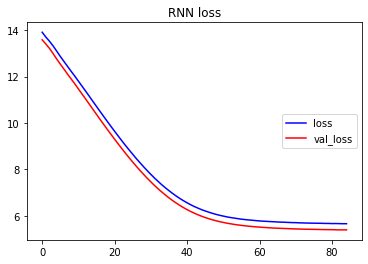

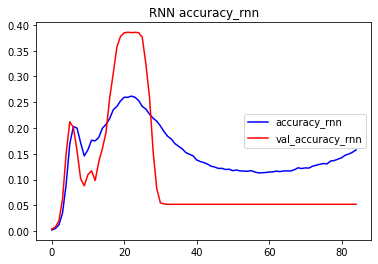

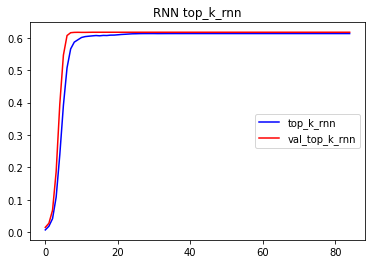

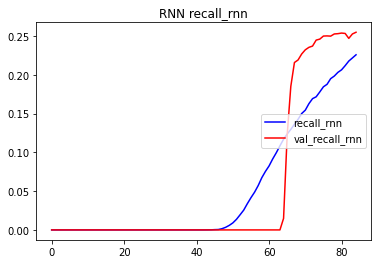

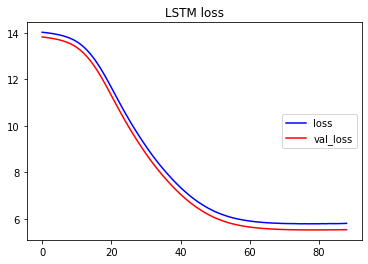

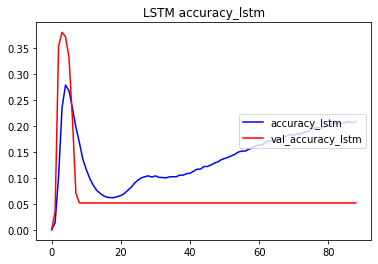

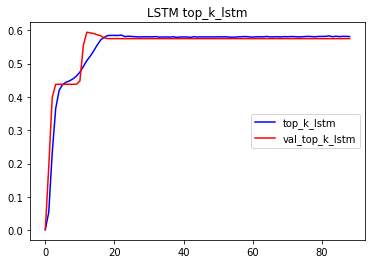

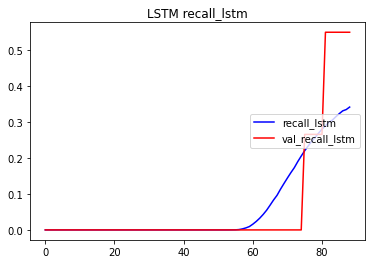

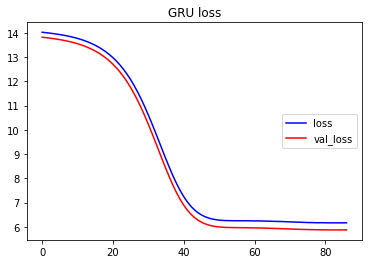

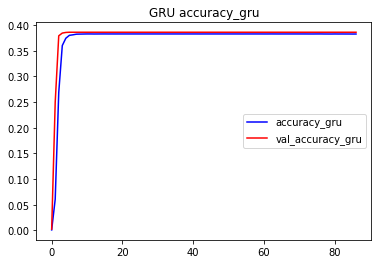

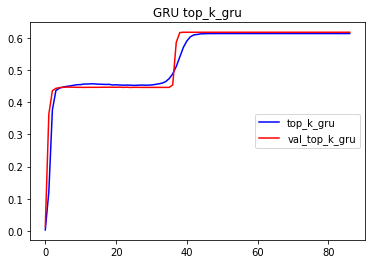

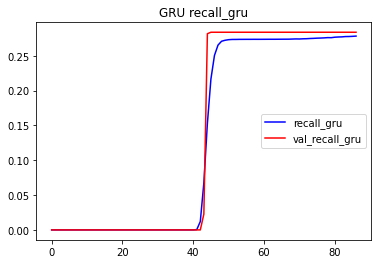

In [131]:
plotting(hist_dict, ["loss", "accuracy", "top_k", "recall"])

In [133]:
rnn_pred = rnn_model(x_test)

In [134]:
lstm_pred = lstm_model(x_test)

In [135]:
gru_pred = gru_model(x_test)

In [147]:
top_k_metric = tf.keras.metrics.TopKCategoricalAccuracy(k=3)
top_k_metric.update_state(y_test, rnn_pred)
print(top_k_metric.result().numpy())
top_k_metric = tf.keras.metrics.TopKCategoricalAccuracy(k=3)
top_k_metric.update_state(y_test, lstm_pred)
print(top_k_metric.result().numpy())
top_k_metric = tf.keras.metrics.TopKCategoricalAccuracy(k=3)
top_k_metric.update_state(y_test, gru_pred)
print(top_k_metric.result().numpy())

0.62997293
0.594438
0.62997293


### Part 3
I don't think we can solve this with feed-forwarding. The text data we are using has both forward and backward contextualization, meaning we need to consider not only what values are present, but what order they occur in for both directions. If this task was as simple as identifying keyword features, I think we might be able to feed-forward this data, but since the task is more complex, I don't think feed-forwarding would be appropriate.